# Real-Time Monitoring of DoS Attacks: Analyse Data of RSDoS Crawler

This notebook runs a very first analysis as part of the real-time monitoring of DoS attacks. The aim of this analysis is to get some first insights into the data of the RSDoS crawler.

*Stefan Scholz* 
*2020-07-22*

In [1]:
import os
import json
import gzip
import pprint
import itertools
import pandas as pd
from datetime import datetime

## Data Preparation

In [2]:
# get dumps
dumps_dir = "../data/"
dumps = [os.path.join(dumps_dir, file) for file in os.listdir(dumps_dir) if file.endswith(".json.gz")]

In [3]:
def date_parser(value):
    """
    Parse dates in dump
    """
    
    if isinstance(value, dict):
        for k, v in value.items():
            value[k] = date_parser(v)
    elif isinstance(value, list):
        for index, row in enumerate(value):
            value[index] = date_parser(row)
    elif isinstance(value, str) and value:
        try:
            value = datetime.strptime(value, "%Y-%m-%dT%H:%M:%S.%f%z")
        except (ValueError, AttributeError):
            pass
    return value

# get attacks
attacks = [json.load(gzip.open(dump, "rt", encoding="utf-8"), object_hook=date_parser)["targets"] for dump in dumps]
attacks = list(itertools.chain.from_iterable(attacks))
attacks = pd.DataFrame(attacks)

## Data Analysis

### Attacks

In [4]:
# get number attacks
print(len(attacks.index))

30


In [5]:
# get time window of start times
print(attacks.start_time.min())
print(attacks.start_time.max())

2020-07-20 13:09:33.232058+00:00
2020-07-20 13:23:13.332630+00:00


<AxesSubplot:title={'center':'Number of attacks per hour'}, xlabel='start_time'>

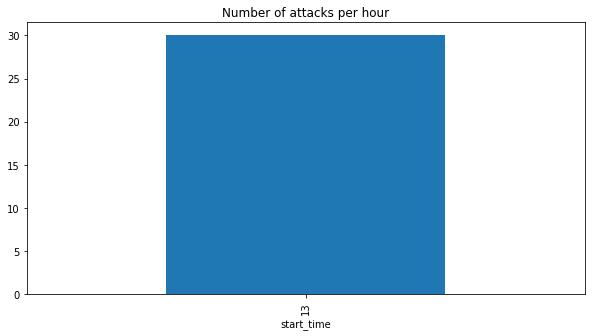

In [6]:
# get number of attacks over time
start_times = pd.to_datetime(attacks.start_time)
attacks.ip.groupby([start_times.dt.hour]).count().plot(kind="bar", figsize=(10,5), title="Number of attacks per hour")

<AxesSubplot:title={'center':'Duration of attacks in minutes'}, ylabel='Frequency'>

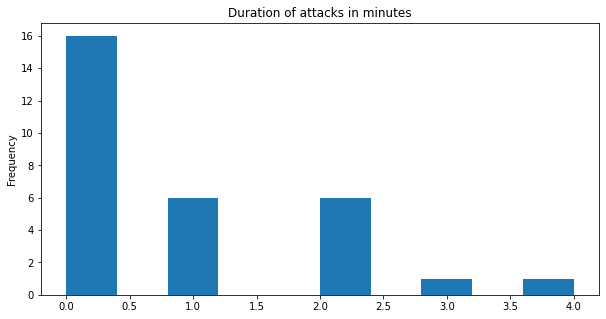

In [7]:
# get duration of attacks
durations = attacks.latest_time - attacks.start_time
durations.astype("timedelta64[m]").plot.hist(figsize=(10,5), title="Duration of attacks in minutes")

<AxesSubplot:title={'center':'Duration of attacks in minutes'}, ylabel='Frequency'>

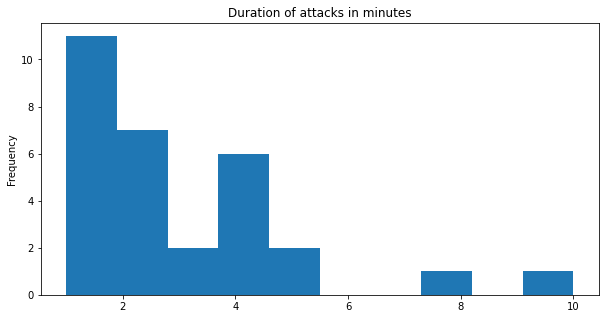

In [8]:
# get number of target lines per attack
target_lines = attacks.target_lines.apply(lambda target_lines: len(target_lines))
target_lines.plot.hist(figsize=(10,5), title="Duration of attacks in minutes")

<AxesSubplot:title={'center':'Time difference between latest time of previous target line and start time of next target line within targets in minutes'}, ylabel='Frequency'>

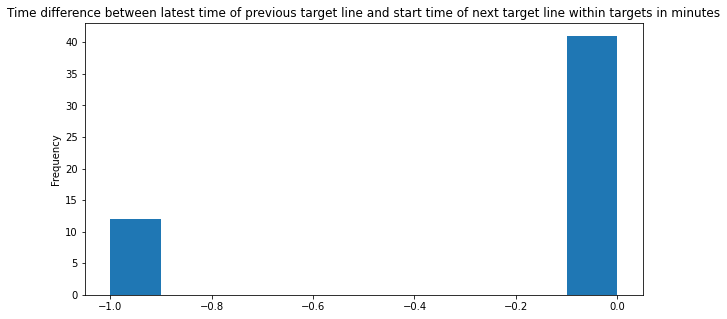

In [9]:
# get time difference between target lines within attack which got merged
differences_within = attacks.target_lines.apply(lambda target_lines: [next_line["start_time"] - previous_line["latest_time"] for previous_line, next_line in zip(target_lines, target_lines[1:])]).explode()
differences_within.astype("timedelta64[m]").plot.hist(figsize=(10,5), title="Time difference between latest time of previous target line and start time of next target line within targets in minutes")

### Targets

In [10]:
# get number distinct targets
print(len(attacks.ip.unique()))

5


<AxesSubplot:title={'center':'Number of attacks on same target'}, ylabel='Frequency'>

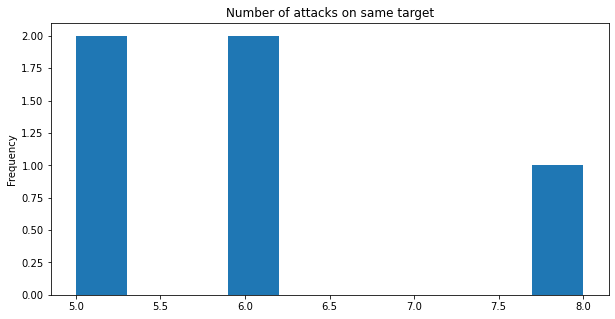

In [11]:
# get number of attacks on same target
attacks.ip.groupby([attacks.ip]).count().plot.hist(figsize=(10,5), title="Number of attacks on same target")

<AxesSubplot:title={'center':'Time difference between latest time of previous attack and start time of next attack across equal targets in minutes'}, ylabel='Frequency'>

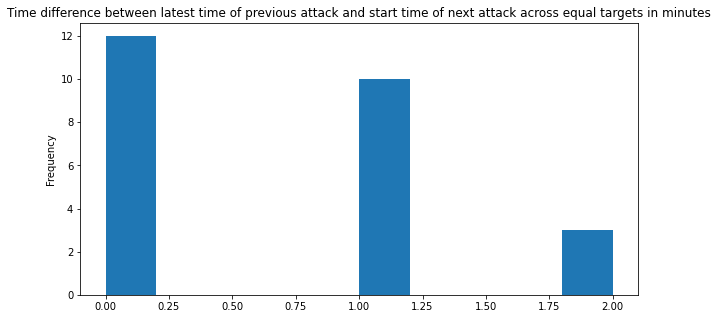

In [12]:
# get time difference between attacks which did not get merged
attacks.sort_values(by=["start_time"], ascending=True, inplace=True)
differences_across = attacks.groupby(attacks.ip).apply(lambda group: [next_target[1]["start_time"] - previous_target[1]["latest_time"] for previous_target, next_target in zip(list(group.iterrows()), list(group.iterrows())[1:])]).explode()
differences_across.astype("timedelta64[m]").plot.hist(figsize=(10,5), title="Time difference between latest time of previous attack and start time of next attack across equal targets in minutes")

### Hosts

In [13]:
# get number of hosts
hosts = attacks.hosts.apply(lambda hosts: list(hosts.keys()))
print(len(hosts.explode().index))

60


In [14]:
# get number of distinct hosts
print(len(hosts.explode().unique()))

11


<AxesSubplot:title={'center':'Number of hosts per attack'}, ylabel='Frequency'>

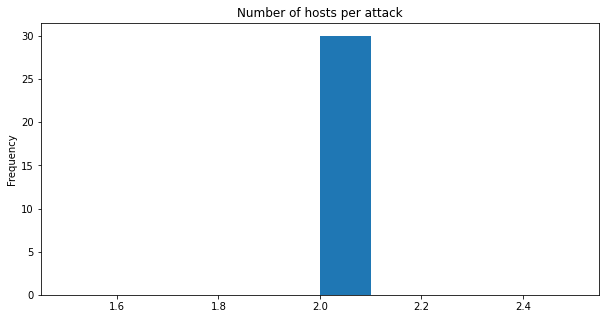

In [15]:
# get number of hosts per attack
hosts.apply(lambda hosts: len(hosts)).plot.hist(figsize=(10,5), title="Number of hosts per attack")

### Crawls

In [16]:
# get number of crawls
crawls = attacks.hosts.apply(lambda hosts: list(itertools.chain.from_iterable(hosts.values())))
print(len(crawls.explode().dropna()))

223


In [17]:
# get number of distinct crawls
print(len(crawls.explode().dropna().apply(lambda crawl: crawl["record"]).unique()))

220


<AxesSubplot:title={'center':'Number of crawls per attack'}, ylabel='Frequency'>

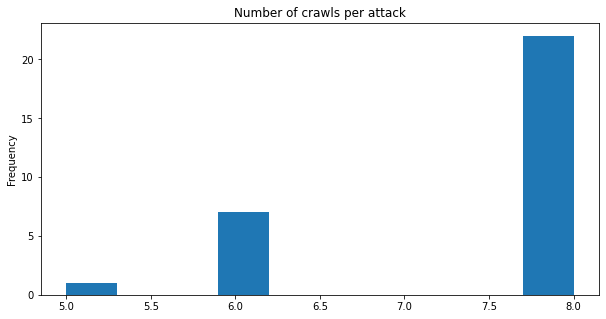

In [18]:
# get number of crawls per attack
crawls.apply(lambda crawls: len(crawls)).plot.hist(figsize=(10,5), title="Number of crawls per attack")

In [19]:
# get number of crawls with status code
print(crawls.explode().dropna().apply(lambda crawl: crawl["status"]).value_counts())

200    165
403     42
404     16
Name: hosts, dtype: int64


In [20]:
# get number of failed hosts which always return non 200 code
hosts_failed = attacks.hosts.apply(lambda hosts: {host: crawls for host, crawls in hosts.items() if all([crawl["status"]>200 for crawl in crawls])})
print(len(hosts_failed.apply(lambda hosts: list(hosts.keys())).explode().dropna().index))

17


In [21]:
# get number of crawls from failed hosts with status codes
crawls_failed = hosts_failed.apply(lambda hosts: list(itertools.chain.from_iterable(hosts.values())))
print(crawls_failed.explode().dropna().apply(lambda crawl: crawl["status"]).value_counts())

403    42
404    16
Name: hosts, dtype: int64
